# 海龟交易系统

## 1 简介
交易系统的几个组成部分：


`
Markets - What to buy or sell     选股
Position Sizing - How much to buy or sell    仓位管理
Entries - When to buy or sell                        入场点
Stops - When to get out of a losing position  止损点
Exits - When to get out of a winning position   止盈点
Tactics - How to buy and sell                          挂单技术
`

## 2 Market
选择流动性好的市场。


流动性如果不好，下单后不能及时成交，如果要成交需要提高价格买或者压低价格卖，流动性越差，这个提高或压低价格的幅度也就也大，这样会很大的影响原来
基于较为平稳的价格产生的成交估算，导致很大的误差发生。

## 3 Position Sizing


`
真实波动值
True Range(TR) = max(H-L, H-PDC, PDC-L)
            其中： H 当日最高价
                  L 当日最低价
                  PDC  昨日收盘价
            N是20日 TR 的移动均值
            原系统给出的N计算公式
`
$$ N = \frac{19 \times PDN + TR}{20} $$

其中：PDN是前一日的N值


不必过分纠结于移动均值，也可以使用更便于理解的均值来替代移动均值。

移动均值的优点：（1）良好的平滑性。 缺点（1）反应不够灵敏；（2）迭代计算，不太容易平行化。（3）计算得到的均值数值和起点有关。

均值的优点：（1）非迭代计算，便于优化。（2）反应灵敏。缺点（1）平滑性比较弱，容易受到极端数值的影响。

均值计算法
$$ N = \frac{N_{-19}+N_{-18} + \cdots + N_{-1} + TR}{20} $$

为了更加严格起见，我们需要验证一下，这种替换的确不会导致较大的误差。
自动生成10000个随机波动数据，看两种算法产生的偏差。
假设波动率是 N(0, 3) 的正态分布，则移动均值和均值的误差 分布大约是 (0, 0.3) 的正太分布。

### 3.1 验证移动均值和均值计算方法之间的误差

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tquotes.tquotes as tq
import tquotes.algos as algos
import math

%matplotlib inline

In [2]:
def iter_compute(series, w=20):
    res = []
    prev = sum(series[:w])/w
    for e in series[w:]:
        cur = (prev*(w-1) + e) / w
        res.append(cur)
        prev=cur
    
    return np.array(res)

In [3]:
def batch_compute(series, w=20):
    res = []
    for i in range(w,len(series)):
        res.append(sum(series[i-w+1:i+1])/w)
    return np.array(res)

In [4]:
# 生成随机的波动率
volatility = np.random.normal(0, 3, 10000)

# 计算移动平均
ma_vols_5 = iter_compute(volatility, w=5)
ma_vols_20 = iter_compute(volatility)
ma_vols_60 = iter_compute(volatility, w=60)
# 计算平均
a_vols_5 = batch_compute(volatility, w=5)
a_vols_20 = batch_compute(volatility)
a_vols_60 = batch_compute(volatility, w=60)


# 获取移动平均和平均的差
diffs_5 = ma_vols_5 - a_vols_5
diffs_20 = ma_vols_20 - a_vols_20
diffs_60 = ma_vols_60 - a_vols_60

print('5 diff mean {:.4f}'.format(np.mean(diffs_5)), 'diff std {:.4f}'.format(np.std(diffs_5)))
print('20 diff mean {:.4f}'.format(np.mean(diffs_20)), 'diff std {:.4f}'.format(np.std(diffs_20)))
print('60 diff mean {:.4f}'.format(np.mean(diffs_60)), 'diff std {:.4f}'.format(np.std(diffs_60)))

5 diff mean 0.0004 diff std 0.6103
20 diff mean 0.0014 diff std 0.3271
60 diff mean 0.0014 diff std 0.1898


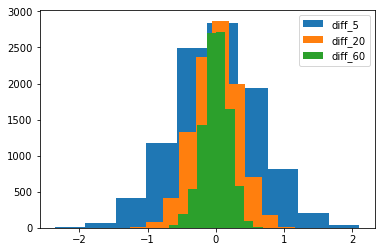

In [5]:
# 绘制 差值 的概率分布
# fig = plt.figure(figsize=(13,8))
plt.hist(diffs_5)
plt.hist(diffs_20)
plt.hist(diffs_60)
plt.legend(labels=['diff_5', 'diff_20', 'diff_60'])

plt.show()

从上面的差值概率统计可以看出，在短周期下，容易产生较大的误差，对于20日以上的中场周期，均值可以近似替代移动均值。

### 3.2 指标值实现

In [6]:
def turtle_tr(bars):
    """
    计算得到 TR 值
    bars 格式 np.ndarray
    tm,open,high,low,close,volume
    """
    highs = bars[:, 2]
    lows = bars[:, 3]
    closes = bars[:, 4].copy()
    close_sh = np.roll(closes, 1)
    close_sh[0] = bars[0][1]  # set the empty prev close to the first open price
    HmL = highs-lows
    HmPDC = highs-close_sh
    PDCmL = close_sh - lows
    
    mat = np.zeros((len(HmL), 3))
    mat[:, 0] = HmL
    mat[:, 1] = HmPDC
    mat[:, 2] = PDCmL
    
    return np.max(mat, axis=1)

In [7]:
def turtle_tr_norm(bars):
    """
    计算得到 TR 值，以百分比的形式表示，TR按照价格计算是有些问题的
    100元的股票和1元的股票，tr值会有很大的差异，不能体现百分比形式的账户变动
    bars 格式 np.ndarray
    tm,open,high,low,close,volume
    """
    highs = bars[:, 2]
    lows = bars[:, 3]
    closes = bars[:, 4].copy()
    close_sh = np.roll(closes, 1)
    close_sh[0] = bars[0][1]  # set the empty prev close to the first open price
    HmL = highs-lows
    HmPDC = highs-close_sh
    PDCmL = close_sh - lows
    
    mat = np.zeros((len(HmL), 3))
    mat[:, 0] = HmL
    mat[:, 1] = HmPDC
    mat[:, 2] = PDCmL
    
    return np.max(mat, axis=1) / close_sh * 100

In [8]:
def turtle_N(trs, wsize=20):
    """
    计算N
    """
    prevn = trs[0]
    N = [prevn]
    for e in trs[1:]:
        N.append(((wsize-1)*prevn+e)/wsize)
    
    return np.array(N)

In [9]:
def turtle_N_average(trs, wsize=20):
    """
    用均值替代移动均值来计算N
    """
    N = np.zeros(trs.shape[0])
    N[0] = trs[0]
    for i in range(1, wsize):
        N[i] = np.sum(trs[:i])/i
    for i in range(wsize,trs.shape[0]):
        N[i] = np.sum(trs[i-wsize+1:i+1])/wsize
    
    return N

In [10]:
dayData = tq.load_day_data('000002')

In [11]:
dayData.head()

,tm,open,high,low,close,volumn,in_money,out_money,amount,prev_close
2012-01-04,20120104,7.47,7.65,7.32,7.33,474329,748590.56,1224538.59,3559734.86,7.47
2012-01-05,20120105,7.31,7.42,7.20,7.25,528117,1016367.58,1440398.42,3872808.23,7.33
2012-01-06,20120106,7.27,7.33,7.06,7.16,542769,671144.99,1505147.33,3893403.32,7.25
2012-01-09,20120109,7.16,7.41,7.08,7.41,846037,1640506.81,1436960.63,6119493.19,7.16
2012-01-10,20120110,7.35,7.61,7.32,7.53,1077976,2375330.45,2297404.70,8049177.86,7.41


In [12]:
bars = dayData[['tm', 'open', 'high', 'low', 'close', 'volumn']].values
# 波动率
trs = turtle_tr(bars)
# 移动平均版的N
ma_Ns = turtle_N(trs)
# 平均版的N
a_Ns = turtle_N_average(trs)

print('number of bars {}.'.format(bars.shape[0]))
print(ma_Ns, ma_Ns.shape[0])
print(a_Ns, a_Ns.shape[0])

number of bars 1268.
[ 0.33    0.3245  0.327  ...,  0.353   0.386   0.377 ] 1268
[ 0.33   0.33   0.275 ...,  0.892  0.925  0.919] 1268


In [13]:
bars = dayData[['tm', 'open', 'high', 'low', 'close', 'volumn']].values
# 波动率
trs_norm = turtle_tr_norm(bars)
# 移动平均版的N
ma_Ns_norm = turtle_N(trs_norm)
# 平均版的N
a_Ns_norm = turtle_N_average(trs_norm)

print(ma_Ns_norm)
print(a_Ns_norm)

[ 4.41767068  4.34685536  4.38299405 ...,  4.33229315  4.44296711
  4.42204433]
[ 4.41767068  4.41767068  3.70951747 ...,  3.2880776   3.384693    3.34518828]


### 3.3 N的不同计算方法，对所求得的N值的影响

比较使用

（1）移动均值的计算方法

（2）均值的计算方法

对所求得的N所产生的误差分析

#### 3.3.1 波动率和两种计算N方法差别的分布

首先，先来看一下波动率的分布，本例子中使用万科A从12年1月4日以来的日线数据。

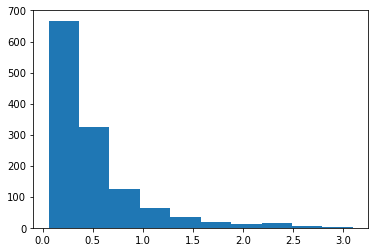

In [14]:
plt.hist(trs)
plt.show()

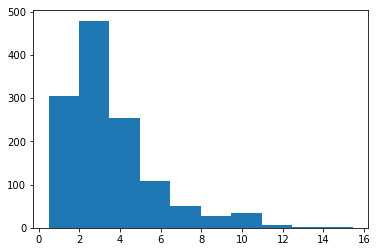

In [15]:
plt.hist(trs_norm)
plt.show()

从上面波动率的结果来看，价格变动服从一个指数分布。涨跌比宾东服从泊松分布。

下面，再来比较两种计算得到的N值之间的差异。

In [16]:
diff_n = ma_Ns - a_Ns
print('diff mean {:.4f}'.format(np.mean(diff_n)), 'diff std {:.4f}'.format(np.std(diff_n)))

diff mean -0.1536 diff std 0.3084


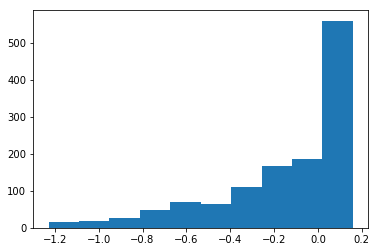

In [17]:
plt.hist(diff_n)
plt.show()

In [18]:
diff_n_norm = ma_Ns_norm - a_Ns_norm
print('norm diff mean {:.4f}'.format(np.mean(diff_n_norm)), 'norm diff std {:.4f}'.format(np.std(diff_n_norm)))

norm diff mean 0.8562 norm diff std 1.2179


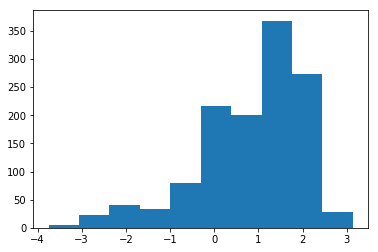

In [19]:
plt.hist(diff_n_norm)
plt.show()

价格差异看着像个半正太分布，或者半studentT分布，价格变动比率的差异像个有偏的正态分布。

验证结果可知，万科A的波动率，使用两种不同的计算N值方法，其价格也只在0.3元左右，价格变动的误差主要在[-0.5%, 2%]之间。

在实际策略中，这两种实现是否可以相互替换使用，还要看后续调整其他参数以适应不同的实现能否达到相同效果。

## 3.4 明确波动率计算的可能疑问

在计算波动率时候，使用了H-L, H-PDC, PDC-L 三者中的最大值作为波动率的度量。

其中H-L 一定是大于0 的了，另外两个可能小于0. 我首先的疑问是，如果拿一个正数和一个负数去做max，是不是有些奇怪了，这里的公式中是否缺少了取绝对值的操作呢？我总是本能的想在这里加个绝对值。

然而，从上面的验证可以知道tr是指数型分布，不可能取到负值。进一步分析后，我才理清除这里确实不需要加绝对值操作。

因为，当日K先和昨天的收盘无外乎两种情形。

（1）今天是上涨行情，则最高价H一定大于PDC，那么只需要考虑L的情况了

     （1.1）如果L小于PDC，则最大者是H-L，次者是H-PDC，其次是PDC - L
     （2.2）如果L大于PDC，则最大者是H-PDC, 其次是H-L，其次是PDC-L 
     
     L的取值，并不会影响到最大值的的波动性的选取。

（2）今天是下跌行情，则最低价L一定小于PDC，PDC-L一定为正，只需要考虑H的情况

      (2.1) 如果H小于PDC，则最大者是PDC-L，其次是H-L，而后是H-PDC
      (2.2) 如果H大于PDC，则最大者是H-L，其次是H-PDC或PDC-L
      
     H的取值，也不会影响到最大值的的波动性的选取。
     
故，不需要取绝对值。


## 3.5 N如何用在仓位控制上

首先，看一下N值的分布情况

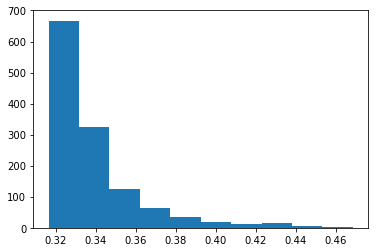

In [20]:
plt.hist(ma_Ns)
plt.show()

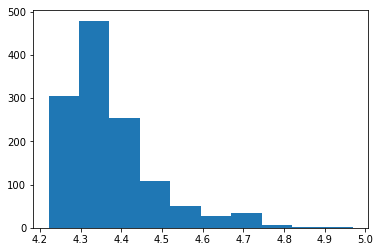

In [31]:
plt.hist(ma_Ns_norm)
plt.show()

N值是TR数值的线性组合，两者无论在理论上，还是从分布的图形上看，都是属于同种分布。从万科A的样本来说，主要分布在区间(0.32, 0.36)

### 3.5.1 现金波动单位

$$ Dollar\ Volatility = N \times Dollars\ per\ Point $$

Dollars per Point 是买卖值的基本单位，如万科A，现在是10.0元，按照A股要求，最低买卖1手，价值为10 * 100 = 1000元。则Dollars per Point是1000元。

由于平均来说，万科A大概每天波动0.35元，如果买入的是1手，就是平均波动 0.35 * 1000 = 350元，这就是现金波动单位。意味着使用日线的情况下，每天增加或减少350元, 连续同方向波动3天，才能完成所有的这一手波动。

海龟操作单位Unit。

$$ Unit = \frac{1 \% \ of\ Account}{Market\ Dollar\ Volatility} = \frac{1 \% \ of\ Account}{N \times Dollar\ per\ Point} $$


假设现在总账户有10万元，1%的账户就是1000元，计算Unit = 1000/350 = 2.857 手，四舍五入得3手。

Level|Type|Maximum Units
---|---|---
1|Single Market| 4 Units
2|Closely Related Market| 6 Units
3|Loosely Related Market| 10 Units
4|Single Direction - Long or Short| 12 Units

Single Market 单个市场最大 4个 Units，以万科A为例，最大持仓12手=12000元，占总账户的12%

Closely Correlated Markets 相关市场最大持仓 6个 Units，房地产类股票，最大持有18手=18000元，占总资产的18%

Loosely Correlated Markets 地产，家电，医药等防御类最大持有10个Units，30手=30000元，占总资产的30%

Single Direction 单方向操作做大持仓 12个Units，全市场最多持有36受=36000元，占总资产的36%

### 3.5.2 调整总账户大小

如果账户缩水 10%，就将总交易账户大小调低原来的20%，也就是从10万调整到8万。

## 4 入场

海龟系统并不很看重入场点的选择，其精华部分在于仓位控制算法。

在原始的海龟系统中，使用的入场点位是Doncbian通道的突破点。Doncbian通道是n日内最高点和最低点的价格构成的区间，当价格上传通道顶价时，发生向上突破，当价格下穿通道底价时，发生向下突破。

入场是可以使用长短期两种系统

系统1 - 20日通道突破短期入场点

    在日内，系统突破20日通道上界后1个tick，（1个tick可以是1分钟，5分钟或30分钟站稳，未回落到通道内），可以建立仓位。
    
    这里还需要记住之前的状态，如果之前已经有一个多头Unit，且处于盈利状态，这个信号就该忽略。但这个清除标记的动作不适用与55日的长周期，长周期通常是更加安全可靠的信号。
    
    如果之前建立的多头，向下移动了2*N个位置，则应该止损之前的头寸，清理掉已经建仓的标记，那么，这个信号就可以使用。

系统2 - 55日通道突破长期入场点

可以使用其中一个，或者按照比例混合使用。混合使用时，如果是50%，50%的混合比例，在系统1发生突破时，拿出准备买入的一半资金，买入系统1点，当系统2发生突破时，再买入另一半资金。

### 4.1 加仓

在第一次建仓的基础上，向上在增加0.5*N个波动单位，可以第二次加仓，这个0.5*N的幅度一定要再第一次成交价格的基础上，而不是突破价格。

4次加仓的上浮幅度相同。

如果N = 1.2；第一次建仓价格是28.3

    则其后每次的加仓价格为
    第一次  28.3
    第二次  28.3 + 0.5*1.2 = 28.9
    第三次  28.9 + 0.5*1.2 = 29.5
    第四次  29.5 + 0.5*1.2 = 30.10

上述规则的执行一定要保持一惯性，因为一年中的主要盈利都集中在2-3次大的交易之内，如果错失了这样的大交易，将会极大的影响到一年的收益情况。

## 5 止损

海龟系统的止损，也是基于平滑波动率N。海龟系统对于止损点的计算是基于总账户对最大回撤的容忍程度，如果总账户最大回撤容忍幅度是2%，则止损点映泰在最后一次建仓成交价格一下2*N的位置上。这以为着，后面多次建仓，建仓价格提高，止损价格也会随之提高。

以原油为例：

    N = 1.2
    55 day breakout price = 28.30
    
Unit Num. | Entry Price | Stop
--- | --- | ---
First Unit | 28.30 | 25.90
Second Unit | 28.90 | 27.10
Third Unit | 29.50 | 27.70
Fourth Unit | 31.80 | 27.40
    
    表格中，随着每次Unit增加，前面所有的Stop价格都调整为新增加的Unit的止损价，如当Second Unit加入后，First Unit的Stop价格调整为27.10


### 5.1 whipsaw 止损

除了上一小节所所的止损之外，还有一种whipsaw止损，这种止损可能导致更多的损失比例，但也是一种可选的方法。这种方法可能会有更多的收益，但从风险收益比来说，比之前的要低。

whipsaw的止损在开仓位置一下的 1/2*N 位置，每个位置的止损价格不会随着后续开仓的发生而发生改变。

还以原油为例：

    N = 1.2
    55 day breakout price = 28.30
    
Unit Num. | Entry Price | Stop
--- | --- | ---
First Unit | 28.30 | 27.70
Second Unit | 28.90 | 28.30
Third Unit | 29.50 | 28.90
Fourth Unit | 30.10 | 29.50

后续的Unit的增加，Stop价格不会发生变化。

## 6 离场

系统1的退场：

    以10天为周期，最高价和最低价建立一个通道，当向下突破通道时，离场多头单子，当向上突破10日时，离场空头单子。

系统2的退场：

    以20天为周期，最高价和最低价建立一个通道，当向下突破通道时，离场多头单子，当向上突破10日时，离场空头单子。




## 7 其他关键点

魔鬼都藏在细节当中，想做好细节很重要。

最好使用限价单，而不是市价单。

交易最强的板块，衡量强度的方法可以是，检查几个候选对象中，每个移动的单位N的个数，移动较多的，定位其为强势品种。


## 8 海龟系统实现


In [38]:
def get_channels(bars, wsize=20):
    """
    计算每个时间点上的通道
    bars格式
    tm,open,high,low,close,volume
    """
    highs = bars[:, 2]
    lows = bars[:, 3]
    mat = np.zeros((highs.shape[0], 2))
    
    for i in range(1, wsize):
        hh = np.max(highs[:i])
        ll = np.min(lows[:i])
        mat[i, 0] = hh
        mat[i, 1] == ll
    
    for i in range(wsize, bars.shape[0]):
        hh = np.max(highs[i-wsize:i])
        ll = np.min(lows[i-wsize:i])
        # 在i处看到的通道是 i-1及其之前共20个元素
        mat[i, 0] = hh
        mat[i, 1] = ll

    return mat

In [47]:
class Account(object):
    def __init__(self, init_capital=100000.0):
        self.cur_capital = init_capital
        self.capital_history = []
        self.agents = []
    
    def register_agent(self, agent):
        if agent not in self.agents:
            self.agents.append(agent)
    
    def remove_agent(self, agent):
        if agent in self.agent:
            self.remove(agent)
    
    def make_snapshot(self, timestampe):
        tot_assets = self.get_total_assets()
        self.capital_history.append([timestampe, tot_assets])
    
    def add_money(self, mny):
        self.cur_capital += mny
    
    def sub_money(self, mny):
        self.cur_capital -= mny
        
    def get_current_money(self):
        # 获取当前可用资金
        return self.cur_capital
    
    def get_total_assets(self):
        # 获取总资产
        mny = 0.0
        for agent in self.agents:
            mny += agent.get_holding_assets()
        
        return self.cur_capital + mny

In [67]:
class TurtleAgent(object):
    def __init__(self, symbol, account):
        # 个股代码
        self.symbol = symbol
        # 账户
        self.account = account
        self.account.register_agent(self)
        
        # 入场信号生成所使用的周期
        self.enter_period = 20
        # 离场信号生成所使用的周期
        self.exit_period = 10
        # dataframe格式的日线数据
        self.data = tq.load_day_data(self.symbol)
        # ndarray格式的日线数据
        self.bars = self.data[['tm', 'open', 'high', 'low', 'close', 'volumn']].values
        # 入场通道数据
        self.enter_channels = get_channels(self.bars, wsize=self.enter_period)
        # 离场通道数据
        self.exit_channles = get_channels(self.bars, wsize=self.exit_period)
        # 平滑波动率 N
        trs = turtle_tr(self.bars)
        self.Ns = turtle_N(trs)
        # 状态 
        # init 可以开仓
        # on   已经有持仓
        # full 仓位已经满了
        self.state = 'init'
        # 当前指向的bar下表
        self.bar_index = -1
        # 当前持有的仓位数
        self.units_num = 0
        # 可以持有的最大仓位书
        self.MAX_UNITS_NUM = 4
        # 下单的单子列表，格式为
        # start_index, price, position_num, stop_price
        self.orders = []
        # 交易记录
        # 格式 order, type
        # type可以是 
        # buy 买入
        # stop 止损
        # exit 离场
        self.trade_logs = []

    def get_stop_price(self):
        if len(self.orders) == 0:
            return -1.0
        
        last_fill_price = self.orders[-1][1]
        nValue = self.Ns[self.bar_index-1]
        return last_fill_price - 2*nValue
        
    def get_holding_assets(self):
        mny = 0.0
        # current bar close price
        cur_price = self.bars[self.bar_index][4]
        
        for order in self.orders:
            mny += order[2]*cur_price*100.0
        
        return mny
    
    def get_buy_quantity(self, fill_price):
        all_assets = self.account.get_total_assets()
        # 
        mny_per_point = fill_price * 100.0
        unit_size = self.Ns[self.bar_index] * mny_per_point
        
        qty = round(0.01*all_assets / unit_size)
        
        return qty
    
    def check_signal(self):
        """
        检查应该发送什么样的信号
        """
        if self.state == 'init':
            # 检查是否可以开新仓
            up_bound, low_bound = self.enter_channels[self.bar_index]
            cur_high = self.bars[self.bar_index][2]
            if cur_high > up_bound:
                return 'buy', up_bound
        elif self.state == 'on':
            # 检查是否可以增仓或止损或退出
            up_bound, low_bound = self.enter_channels[self.bar_index]
            cur_high = self.bars[self.bar_index][2]
            cur_low = self.bars[self.bar_index][3]
            if cur_high > up_bound:
                # 检查当前的最高价，是否已经超过了上次开仓价+0.5N的位置，如果是，可以增仓
                last_fill_price = self.orders[-1][1]
                nValue = self.Ns[self.bar_index]
                if cur_high > last_fill_price + 0.5*nValue:
                    return 'buy', up_bound
            
            last_stop_price = self.orders[-1][3]
            if cur_low < last_stop_price:
                # 触发止损
                return 'stop', last_stop_price

            up_bound, low_bound = self.exit_channles[self.bar_index]
            if cur_low < low_bound:
                # 退场信号
                return 'exit', low_bound
        elif self.state == 'full':
            # 检查是否需要平仓或止损
            up_bound, low_bound = self.exit_channles[self.bar_index]
            cur_low = self.bars[self.bar_index][3]
            if cur_low < low_bound:
                # 满足退场条件
                return 'exit', low_bound
            
            last_stop_price = self.orders[-1][3]
            if cur_low < last_stop_price:
                return 'stop', last_stop_price
        
        return '', -1.0

    def run_sim(self):
        """
        执行模拟
        """
        for i in range(20, self.bars.shape[0]):
            self.bar_index = i
            signal, signal_price = self.check_signal()
            if signal == 'buy':
                # 计算购买数量，下单，生成止损价格并填充，更新账户可用现金
                qty = self.get_buy_quantity(signal_price)
                order = [self.bar_index, signal_price, qty, -1.0]
                self.orders.append(order)
                stop_price = self.get_stop_price()
                order[3] = stop_price
                self.units_num += 1
                mny = qty*signal_price*100.0
                self.account.sub_money(mny)
                self.state = 'on'                
                if self.units_num == self.MAX_UNITS_NUM:
                    self.state = 'full'
                print("buy stock at {} quantity {} price {}, {}/{} units {}".format(self.bars[self.bar_index][0], qty, signal_price, self.units_num, self.MAX_UNITS_NUM, self.state))
            elif signal == 'stop':
                # 取出所有订单，计算卖出产生的资金，将资金加入到账户中，删除这些订单
                mny = 0.0
                totqty = 0.0
                for order in self.orders:
                    mny += signal_price * order[2] * 100
                    totqty += order[2]
                    
                self.orders = []
                self.account.add_money(mny)

                self.state = 'init'
                self.units_num = 0
                print('stop stock at {} quantity {} price {}, {}/{} units {}'.format(self.bars[self.bar_index][0], totqty, signal_price, self.units_num, self.MAX_UNITS_NUM ,self.state))
            elif signal == 'exit':
                # 取出所有订单，计算卖出产生的资金，将资金加入到账户中，删除这些订单
                mny = 0.0
                totqty = 0.0
                for order in self.orders:
                    mny += signal_price * order[2] * 100
                    totqty += order[2]
                
                self.orders = []
                self.account.add_money(mny)
                
                self.state = 'init'
                self.units_num = 0
                print('exit stock at {} quantity {} price {}, {}/{} units {}'.format(self.bars[self.bar_index][0], totqty, signal_price, self.units_num, self.MAX_UNITS_NUM, self.state))
            self.account.make_snapshot(self.bars[i][0])


In [68]:
account = Account()
agent = TurtleAgent('000002', account)

agent.run_sim()
print('done')

buy stock at 20120210.0 quantity 4.0 price 7.96, 1/4 units on
buy stock at 20120222.0 quantity 4.0 price 8.02, 2/4 units on
buy stock at 20120223.0 quantity 4.0 price 8.2, 3/4 units on
buy stock at 20120224.0 quantity 4.0 price 8.3, 4/4 units full
exit stock at 20120315.0 quantity 16.0 price 8.24, 0/4 units init
buy stock at 20120412.0 quantity 4.0 price 8.69, 1/4 units on
buy stock at 20120425.0 quantity 3.0 price 8.8, 2/4 units on
buy stock at 20120426.0 quantity 4.0 price 8.91, 3/4 units on
buy stock at 20120427.0 quantity 3.0 price 9.02, 4/4 units full
exit stock at 20120515.0 quantity 14.0 price 8.84, 0/4 units init
buy stock at 20120529.0 quantity 3.0 price 9.29, 1/4 units on
buy stock at 20120530.0 quantity 3.0 price 9.38, 2/4 units on
stop stock at 20120625.0 quantity 6.0 price 8.725000000000001, 0/4 units init
buy stock at 20120706.0 quantity 3.0 price 9.44, 1/4 units on
buy stock at 20120709.0 quantity 3.0 price 9.65, 2/4 units on
buy stock at 20120716.0 quantity 3.0 price 9.

In [70]:
mnys = [row[1] for row in account.capital_history]


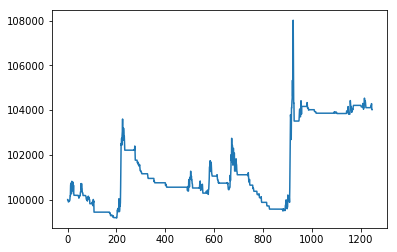

In [71]:
plt.plot(mnys)
plt.show()